In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
from skimage.transform import resize

# Télécharger les poids et le dataset

In [2]:
!gdown --id "1QuuAg5ieStJ-79SaLFXMMwhaPnE67552" --output weights_resnet.pt

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1QuuAg5ieStJ-79SaLFXMMwhaPnE67552
From (redirected): https://drive.google.com/uc?id=1QuuAg5ieStJ-79SaLFXMMwhaPnE67552&confirm=t&uuid=2d65ae23-c2d1-45fb-8810-f6fee03cb53e
To: /content/weights_resnet.pt
100% 44.8M/44.8M [00:01<00:00, 29.3MB/s]


In [3]:
!gdown --id "1TmFaZ4BczAsuh5aL-D6ey6h25fmJZ0Tc" --output vgg_imagenette.pt

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TmFaZ4BczAsuh5aL-D6ey6h25fmJZ0Tc
From (redirected): https://drive.google.com/uc?id=1TmFaZ4BczAsuh5aL-D6ey6h25fmJZ0Tc&confirm=t&uuid=14162851-c25f-4dc3-b576-4ed58c79f0ed
To: /content/vgg_imagenette.pt
100% 185M/185M [00:02<00:00, 77.6MB/s]


In [4]:
!gdown --id "1P3tOCc0dBlYN_a-58ksaHW7HcyYa77vJ" --output imagenette2.tgz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1P3tOCc0dBlYN_a-58ksaHW7HcyYa77vJ
From (redirected): https://drive.google.com/uc?id=1P3tOCc0dBlYN_a-58ksaHW7HcyYa77vJ&confirm=t&uuid=a70aaf22-2ca0-46b9-b9f4-bd68b64066cb
To: /content/imagenette2.tgz
100% 1.56G/1.56G [00:32<00:00, 47.3MB/s]


In [5]:
!tar -xzf imagenette2.tgz

# 1. Implementation of RISE

RISE is an explanation method designed to create an importance map indicating the significance of each pixel for the black-box model's prediction, by empirically estimating pixel importance through randomly masked input images.

The core concept consists on randomly masking parts of the input image and observing its responses. The resulting importance map is created by linearly combining these random masks based on the model's predictions for each masked image: the weights come from the score of the target class corresponding to the respective masked inputs.

### Create RISE method

In [6]:
import numpy as np
import torch
import torch.nn as nn
from skimage.transform import resize
from tqdm import tqdm


class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=200):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch
    ### Generate masks for RISE method
    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size
        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')
        self.masks = np.empty((N, *self.input_size))
        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        # Save the computed masks
        np.save(savepath, self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def forward(self, x):
      # Compute masks for a specific image
      with torch.no_grad():
          preds = []
          N = self.N
          _, _, H, W = x.size()
          model = self.model
          model.eval()
          masked = x * self.masks
          for i in tqdm(range(0, N, self.gpu_batch), desc='Explaining'):
              preds.append(model(masked[i:min(i+self.gpu_batch, N)]))
          preds = torch.cat(preds)
          sal = torch.matmul(preds.data.transpose(0, 1), self.masks.view(N, H * W))
          CL = preds.size(1)
          sal = sal.view((CL, H, W))
          sal = sal / N / self.p1
          return sal



# 2 Explanation for a specific model

### Define RISE explainer

In [7]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

def load_img(path):
    #Open the image
    img = Image.open(img_path)
    #Apply transformation for preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])
    img = transform(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return img, x

def explain_model(model, img_path) :
    explainer = RISE(model, input_size=(224, 224), gpu_batch=200)
    #generate mask
    explainer.generate_masks(N=6000, s=8, p1=0.5, savepath="./")
    #load im
    img, x = load_img(img_path)

    x_copy = x.copy()

    x_tensor = torch.tensor(x_copy, device="cuda")
    saliency = explainer(x_tensor)

    saliency = saliency.cpu()
    saliency_map = saliency.permute(1, 2, 0)
    image_originale = img.permute(1,2,0)
    image_originale = np.clip(image_originale, 0, 255)

    fig, ax = plt.subplots()
    ax.imshow(image_originale)
    cax = ax.imshow(saliency_map[:,:,0], cmap='jet', alpha=0.5)
    fig.colorbar(cax)
    plt.title('Saliency map and original image')
    plt.show()
    return x_tensor, saliency

In [10]:
from torchvision.models import resnet18

resnet18 = resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 10)
#Load the pretrained weights on imagenette
resnet18.load_state_dict(torch.load('./weights_resnet.pt'), strict=False)
resnet18 = resnet18.cuda()
x_tensor_resnet, saliency_resnet = explain_model(resnet18, "./imagenette2/val/ILSVRC2012_val_00009111.JPEG")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Explain for VGG16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]
Explaining: 100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


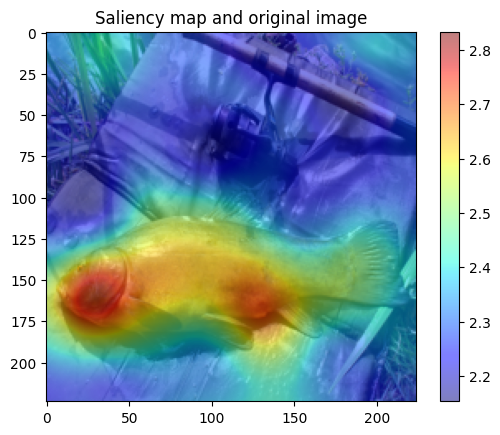

In [ ]:
import torchvision.models as models
import torch
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] =  torch.nn.Linear(in_features=4096, out_features=10, bias=True)
vgg16.load_state_dict(torch.load('./vgg_imagenette.pt'), strict=False)
vgg16 = vgg16.cuda()
x_tensor_vgg, saliency_vgg = explain_model(vgg16, "./imagenette2/val/ILSVRC2012_val_00009111.JPEG")

# 2. Metrics implementation

In explainable machine learning, we still don't have a widely agreed-upon method to measure a model's explainability. In the RISE paper they introduce 2 metrics :
- The deletion metric that evaluates the impact of removing important pixels on the model's decision-making process.
- The insertion metric that assesses the effect of introducing pixels on the model's decision.

### Method to plot a tensor

In [ ]:
def tensor_imshow(inp, title=None, **kwargs):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, **kwargs)
    if title is not None:
        plt.title(title)


### Deletion metric

In [ ]:
def deletion_metric(model, step, substrate_fn, img_tensor, explanation, verbose=1, save_to=None):
    HW = 224*224
    model.eval()
    pred = model(img_tensor.cuda())
    _, c = torch.max(pred, 1)
    c = c.cpu().numpy()[0]
    n_steps = (HW + step - 1) // step
    start = img_tensor.clone()
    finish = substrate_fn(img_tensor)
    scores = np.empty(n_steps + 1)
    # Coordinates of pixels
    salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1).cpu().numpy(), axis=-1)
    for i in range(n_steps + 1):
        pred = model(start.cuda())
        scores[i] = torch.nn.functional.softmax(pred, dim=1)[0, c].item()

        if i < n_steps:
            coords = salient_order[:, step * i:step * (i + 1)].flatten()
            start_view = start.view(-1)
            finish_view = finish.view(-1)
            start_view[coords] = finish_view[coords]
            start = start_view.view_as(start)
    if verbose > 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title(f'Pixels deleted 100.0%, P={scores[-1]:.4f}')
        plt.axis('off')
        tensor_imshow(start[0])
        plt.subplot(122)
        plt.plot(np.linspace(0, 1, n_steps + 1), scores)
        plt.title('Deletion game')
        plt.xlabel('Pixels deleted')
        plt.ylabel('Prediction confidence')
        plt.ylim(0, 1.05)
        plt.fill_between(np.linspace(0, 1, n_steps + 1), 0, scores, alpha=0.4)
        plt.show()

    return scores

In [ ]:
def insertion_metric(model, step, substrate_fn, img_tensor, explanation, verbose=1, save_to=None):
    HW = 224*224
    model.eval()
    pred = model(img_tensor.cuda())
    _, c = torch.max(pred, 1)
    c = c.cpu().numpy()[0]
    n_steps = (HW + step - 1) // step

    start = substrate_fn(img_tensor)
    finish = img_tensor.clone()

    scores = np.empty(n_steps + 1)
    salient_order = np.flip(np.argsort(explanation.reshape(-1, HW), axis=1).cpu().numpy(), axis=-1)

    for i in range(n_steps + 1):
        pred = model(start.cuda())
        scores[i] = torch.nn.functional.softmax(pred, dim=1)[0, c].item()

        if i < n_steps:
            coords = salient_order[:, step * i:step * (i + 1)].flatten()
            start_view = start.view(-1)
            finish_view = finish.view(-1)
            start_view[coords] = finish_view[coords]
            start = start_view.view_as(start)
    if verbose > 0:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title(f'Pixels inserted 100.0%, P={scores[-1]:.4f}')
        plt.axis('off')
        tensor_imshow(start[0])
        plt.subplot(122)
        plt.plot(np.linspace(0, 1, n_steps + 1), scores)
        plt.title('Insertion game')
        plt.xlabel('Pixels inserted')
        plt.ylabel('Prediction confidence')
        plt.ylim(0, 1.05)
        plt.fill_between(np.linspace(0, 1, n_steps + 1), 0, scores, alpha=0.4)
        plt.show()

    return scores

### Test of the two metrics with Resnet18 model

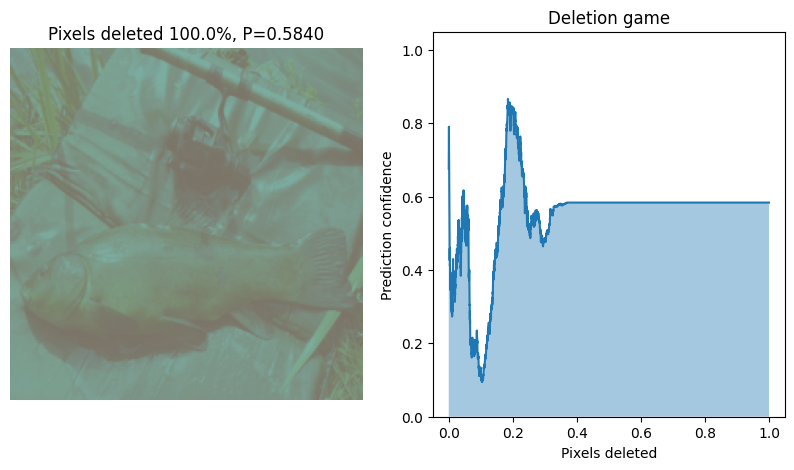

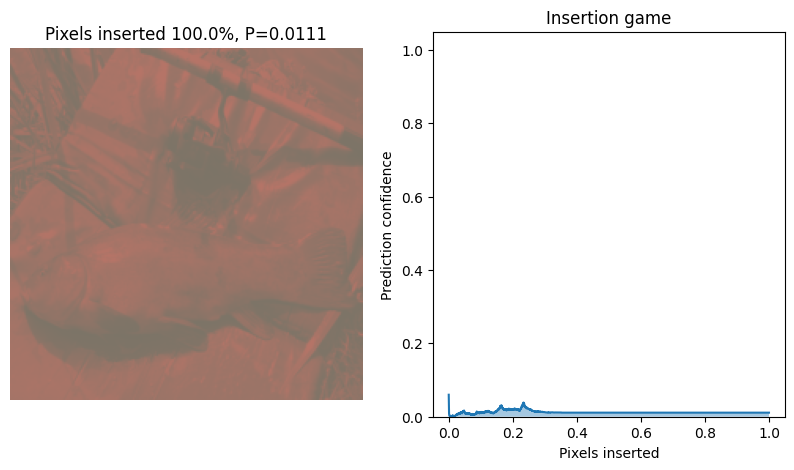

In [ ]:
def substrate_fn(img_tensor):
    return torch.zeros_like(img_tensor)

deletion_scores = deletion_metric(resnet18, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_resnet, explanation=saliency_resnet, verbose=1, save_to='deletion')
insertion_scores = insertion_metric(resnet18, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_resnet, explanation=saliency_resnet, verbose=1, save_to='insertion')


### Test of the two metrics with VGG16 model

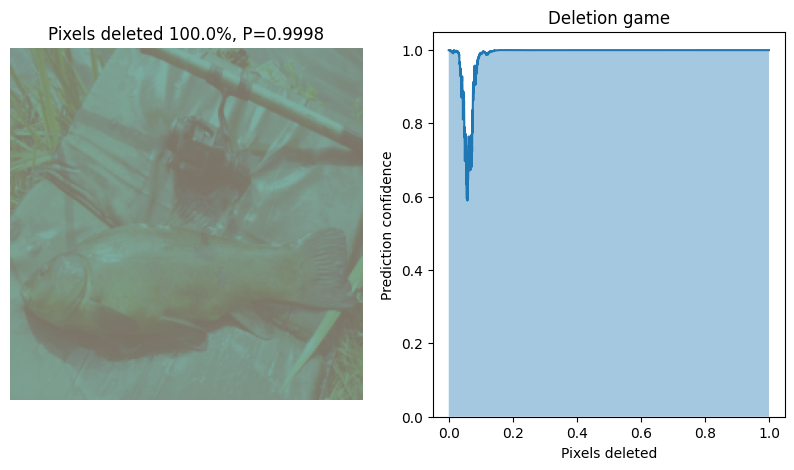

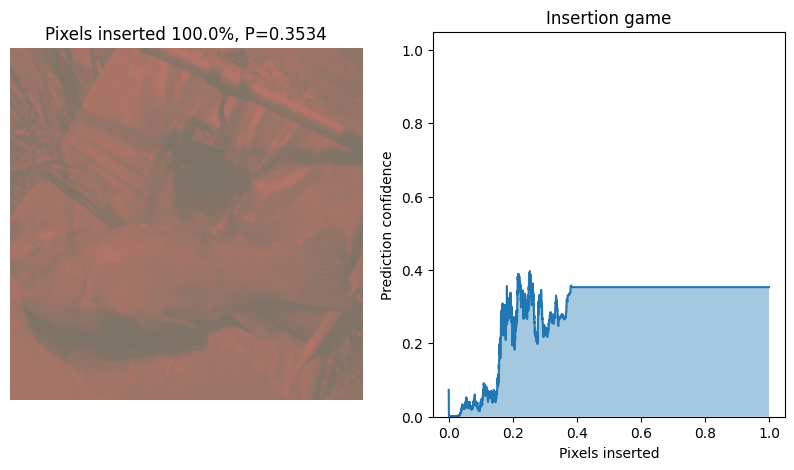

In [ ]:
deletion_scores = deletion_metric(vgg16, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_vgg, explanation=saliency_vgg, verbose=1, save_to='deletion')
insertion_scores = insertion_metric(vgg16, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_vgg, explanation=saliency_vgg, verbose=1, save_to='insertion')

# 3. Comparision with GradCAM method
Grad-CAM (Gradient-weighted Class Activation Mapping) is another technique used to visualize and understand which parts of an image a convolutional neural network (CNN) focuses on when making a prediction. Here we are using this method to compare it with RISE (on resnet18 and VGG16).

In [ ]:
pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5249 sha256=bb66135224f383cbb21c69cf7f4b223bae087355c9c23a1f04570ef373441022
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
from gradcam.utils import visualize_cam
from torchvision.transforms import functional as TF
from gradcam.utils import visualize_cam
from gradcam import GradCAM

def generate_mask_grad_cam(model, target_layer, target_class, x_tensor):

    grad_cam = GradCAM(model, target_layer=target_layer)
    def generate_gradcam(img_tensor, target_class):
        mask, _ = grad_cam(img_tensor, target_class)
        return mask.squeeze(0)

    explanation = generate_gradcam(x_tensor, target_class)
    visualization = visualize_cam(explanation, x_tensor)
    heatmap = np.transpose(visualization[1], (1, 2, 0))

    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.show()
    return explanation


### 3.1 Compute masks and metrics for GradCAM with resnet18

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


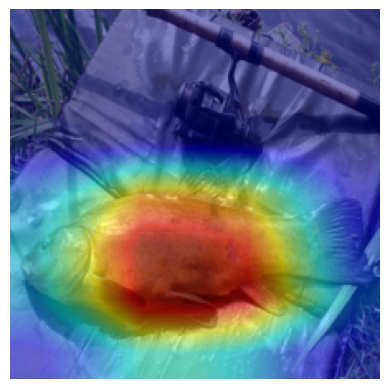

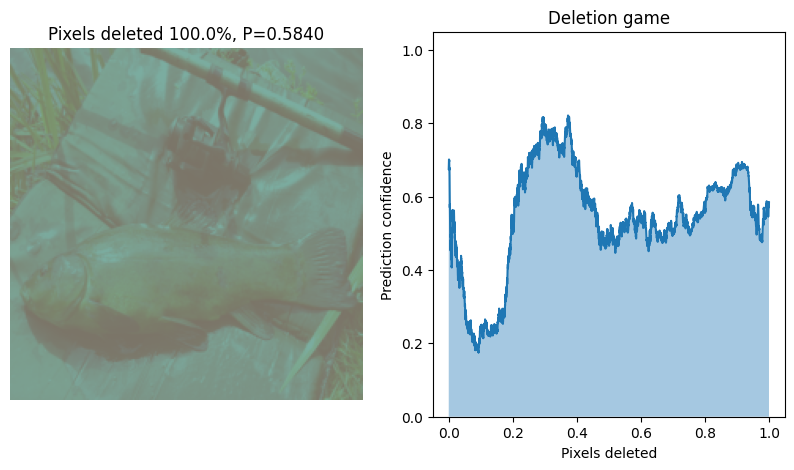

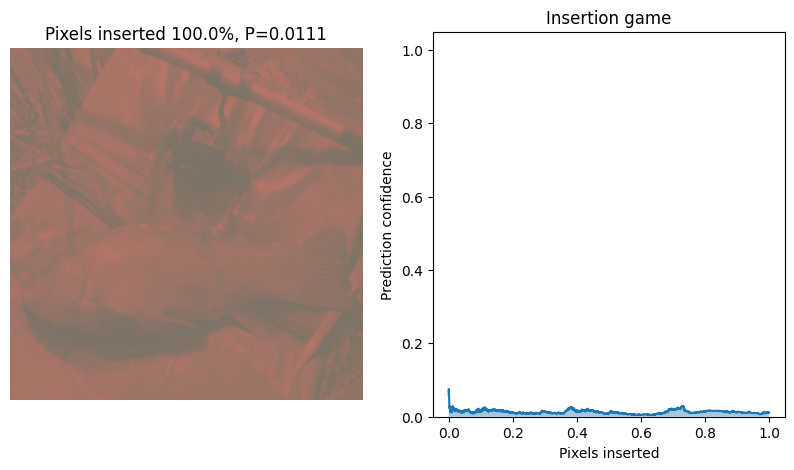

In [ ]:
explanation_resnet18 = generate_mask_grad_cam(resnet18, resnet18.layer4[-1], target_class=0, x_tensor = x_tensor_resnet)
deletion_scores = deletion_metric(resnet18, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_resnet, explanation=explanation_resnet18.cpu(), verbose=1, save_to='deletion')
insertion_scores = insertion_metric(resnet18, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_resnet, explanation=explanation_resnet18.cpu(), verbose=1, save_to='insertion')

### 3.2 Compute masks and metrics for GradCAM with VGG16

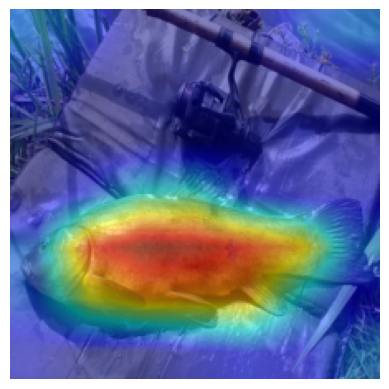

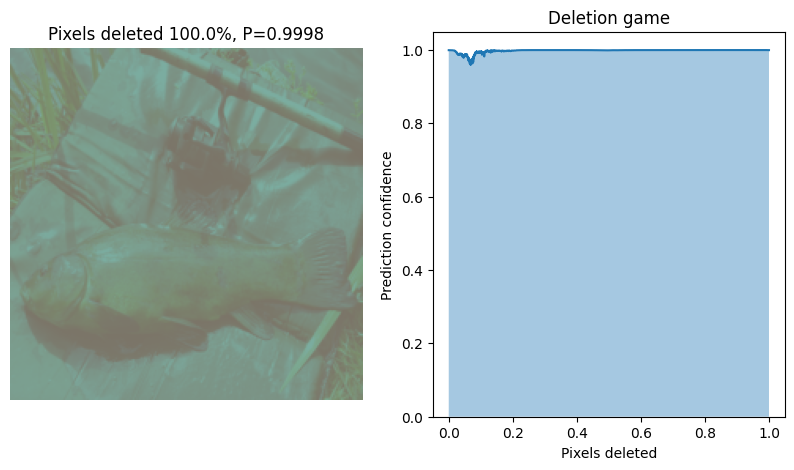

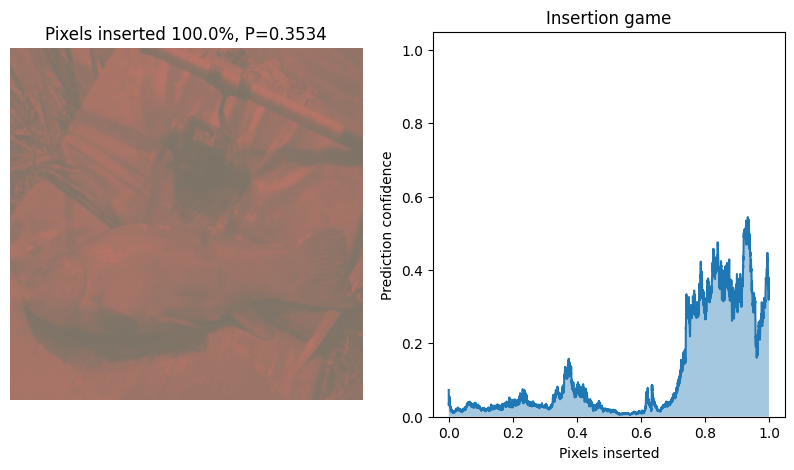

In [ ]:
explanation_vgg = generate_mask_grad_cam(vgg16, vgg16.features, target_class=0, x_tensor = x_tensor_vgg)
deletion_scores = deletion_metric(vgg16, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_vgg, explanation=explanation_vgg.cpu(), verbose=1, save_to='deletion')
insertion_scores = insertion_metric(vgg16, step=10, substrate_fn=substrate_fn, img_tensor=x_tensor_vgg, explanation=explanation_vgg.cpu(), verbose=1, save_to='insertion')